In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
import numpy as np
# Fixing numpy random seed
np.random.seed(42)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

In [28]:


# Reading in the dataset
df = pd.read_csv('data/data.csv')

# Splitting the dataset into features (X) and target variable (y)
X = df.drop('MSRP', axis=1)
y = df['MSRP']

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Printing the shapes of the training and testing sets
print("Training set shape: X={}, y={}".format(X_train.shape, y_train.shape))
print("Testing set shape: X={}, y={}".format(X_test.shape, y_test.shape))


Training set shape: X=(9531, 15), y=(9531,)
Testing set shape: X=(2383, 15), y=(2383,)


## Todo
### > outlier treatment
### > see if same categories are repeating in different case

## EDA

In [29]:
y_train.describe()

count    9.531000e+03
mean     4.080480e+04
std      6.261255e+04
min      2.000000e+03
25%      2.105750e+04
50%      2.999000e+04
75%      4.244250e+04
max      2.065902e+06
Name: MSRP, dtype: float64

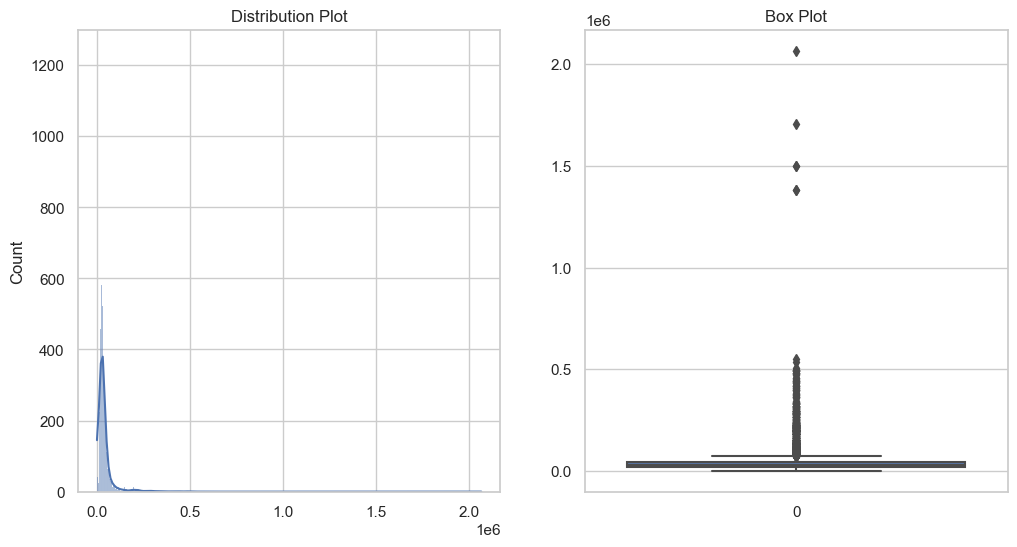

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plot a distribution plot (distplot) of y_train
sns.set(style='whitegrid')
sns.histplot(list(y_train), kde=True, ax=axes[0])
axes[0].set_title('Distribution Plot')

# plot a boxplot of y_train
sns.boxplot(list(y_train), ax=axes[1])
axes[1].set_title('Box Plot')

# show the plots
plt.show()


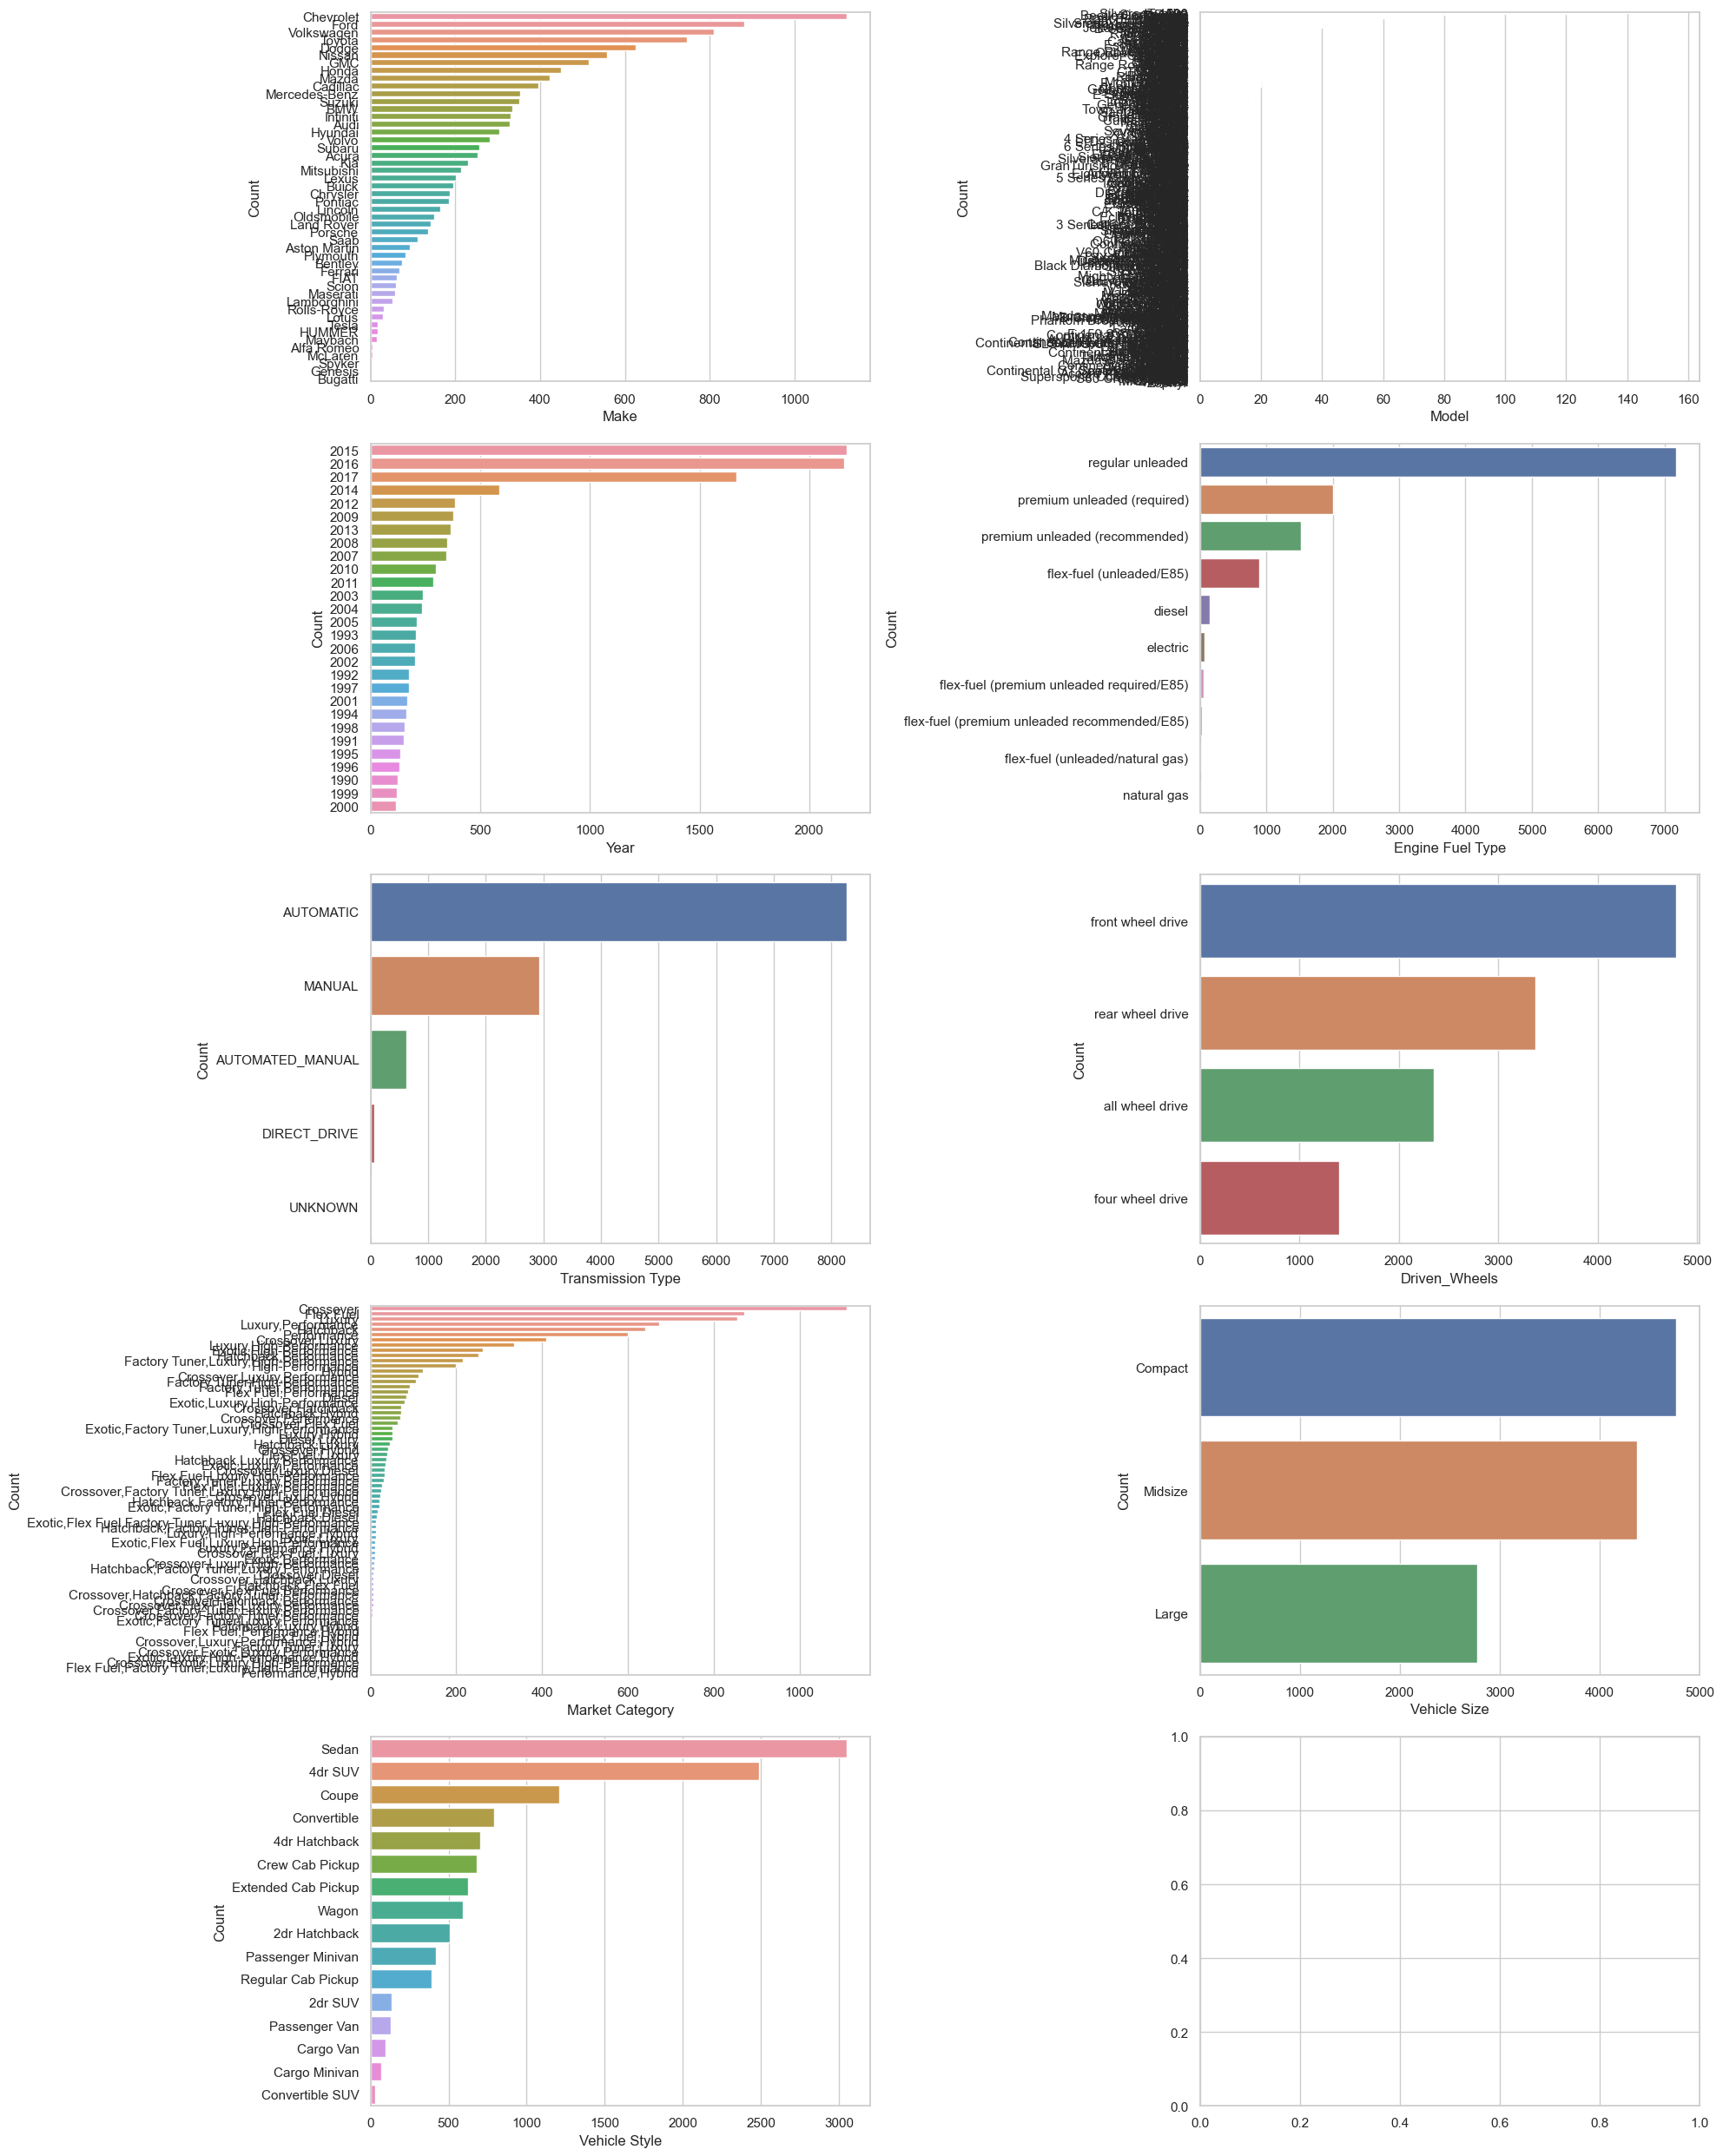

In [31]:
cat_cols = ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Transmission Type',     
                    'Driven_Wheels','Market Category', 'Vehicle Size', 'Vehicle Style']

fig, axs = plt.subplots(5, 2, figsize=(20, 25))
axs = axs.flatten()

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()
    order = counts.index
    sns.countplot(data=df, y=col, order=order, ax=axs[i])
    axs[i].set_xlabel(col, fontsize=12)
    axs[i].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


In [32]:


class ModelTrainer:
    def __init__(self, model_name, model, x_train, y_train, x_test, y_test):
        self.model_name = model_name
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.best_model = None
        self.best_params = None
        self.train_score = None
        self.cv_score = None
        self.test_score = None

    def train_model(self, param_grid, cv=5):
        grid_search = GridSearchCV(self.model, param_grid=param_grid, cv=cv)
        grid_search.fit(self.x_train, self.y_train)
        self.best_params = grid_search.best_params_
        self.best_model = grid_search.best_estimator_
        self.best_model.fit(self.x_train, self.y_train)
        y_train_pred = self.best_model.predict(self.x_train)
        y_test_pred = self.best_model.predict(self.x_test)
        self.train_score = self._get_scores(self.y_train, y_train_pred)
        self.cv_score = self._get_cv_scores()# np.mean(grid_search.cv_results_['mean_test_score'])
        self.test_score = self._get_scores(self.y_test, y_test_pred)

    def _get_scores(self, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - self.x_train.shape[1] - 1)
        return {'R-squared': r2, 'RMSE': rmse, 'MAPE': mape, 'Adjusted R-squared': adj_r2}
    def _get_cv_scores(self):


        # Compute evaluation metrics
        r2_scores = cross_val_score(self.best_model, self.x_train, self.y_train, cv=5, scoring='r2')
        adj_r2_scores = 1 - (1 - r2_scores) * (len(self.y_train) - 1) / (len(self.y_train) - self.x_train.shape[1] - 1)
        mse_scores = -cross_val_score(self.model, self.x_train, self.y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(mse_scores)
        mape_scores = -cross_val_score(self.model, self.x_train, self.y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

        # Store evaluation metrics in a dictionary
        return {
            'R-squared': r2_scores.mean(),
            'RMSE': rmse_scores.mean(),
            'MAPE': mape_scores.mean(),
            'Adjusted R-squared': adj_r2_scores.mean()
        }

    def print_scores(self):
        
        for i in ['R-squared', 'RMSE', 'MAPE', 'Adjusted R-squared']:
            table = PrettyTable()
            table.field_names = ["Model", f"Train {i} ", f"CV {i} ", f"Test {i} "]
            table.add_row([self.model_name, self.train_score[i], self.cv_score[i], self.test_score[i]])
            print(table)
def print_scores_models(model_dict):
    
    for i in ['R-squared', 'RMSE', 'MAPE', 'Adjusted R-squared']:
            for model in model_dict.keys():
                table = PrettyTable()
                table.field_names = ["Model", f"Train {i} ", f"CV {i} ", f"Test {i} "]
                table.add_row([model.model_name, model.train_score[i], model.cv_score[i], model.test_score[i]])
                print(table)

In [33]:
cat_cols = ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Transmission Type', 
            'Driven_Wheels', 'Market Category','Vehicle Size', 'Vehicle Style']

num_cols = ['Engine HP', 'Engine Cylinders', 'Number of Doors','highway MPG','city mpg','Popularity' ]

target = 'MSRP'

## Preprocessing pipeline

In [34]:
num_pipeline = Pipeline(
    [
    ("imputer", SimpleImputer(strategy='median')),
    ("standardscaler",StandardScaler())

    ]
)

cat_pipeline = Pipeline(
    [
    ("imputer", SimpleImputer(strategy='constant', fill_value='Missing')),
    ("encoder",OneHotEncoder(handle_unknown='infrequent_if_exist' ,min_frequency=0.05
                             ))

    ]
)

preprocessor = ColumnTransformer(
    [
    ("num", num_pipeline, num_cols),
    ("cat",cat_pipeline, cat_cols)
    ]
)
"""preprocessed_X_test = preprocessor.fit_transform(X_test)
preprocessed_X_test.columns"""

'preprocessed_X_test = preprocessor.fit_transform(X_test)\npreprocessed_X_test.columns'

## Decision Tree Regressor

In [35]:
model_dict = dict()


In [36]:

decisiontree_pipeline = Pipeline(
    [
    ('preprocessor',preprocessor),
    ("decisiontree",DecisionTreeRegressor(random_state=42))
    ]
)

model_dict['DecisionTreeRegressor'] = ModelTrainer('DecisionTreeRegressor',decisiontree_pipeline, X_train, y_train, X_test, y_test)

param_grid = {
    'decisiontree__max_depth': [3, 5, 7, 9],# controls the maximum depth of the tree. 
                                            # A deeper tree can better fit the training data, but may also overfit.

    'decisiontree__min_samples_split': [2, 5, 10,], # sets the minimum number of samples required to split an internal node. 
                                                #Increasing this parameter can prevent the tree from splitting too early and overfitting.
    'decisiontree__splitter':["best", "random"],# setting splitter to "random" can be a useful strategy for preventing overfitting,
                                            # but it should be used with caution and balanced with other regularization techniques
    'decisiontree__min_samples_leaf': [ 2, 4, 8], # sets the minimum number of samples required to be at a leaf node. 
                                                    #Increasing this parameter can also prevent overfitting.
    'decisiontree__max_features': [1, 'sqrt',0.7,0.8,0.9] # controls the maximum number of features used to make a split decision.
                                                        # Reducing the number of features can prevent overfitting.
}
model_dict['DecisionTreeRegressor'].train_model( param_grid, cv=5)
model_dict['DecisionTreeRegressor'].print_scores()

+-----------------------+--------------------+--------------------+--------------------+
|         Model         |  Train R-squared   |   CV R-squared     |  Test R-squared    |
+-----------------------+--------------------+--------------------+--------------------+
| DecisionTreeRegressor | 0.9571884780710188 | 0.8919996370793696 | 0.9117341105154682 |
+-----------------------+--------------------+--------------------+--------------------+
+-----------------------+--------------------+--------------------+--------------------+
|         Model         |    Train RMSE      |      CV RMSE       |     Test RMSE      |
+-----------------------+--------------------+--------------------+--------------------+
| DecisionTreeRegressor | 12954.449493380993 | 18363.078441093134 | 14504.755231177089 |
+-----------------------+--------------------+--------------------+--------------------+
+-----------------------+---------------------+---------------------+--------------------+
|         Model    

# RandomForestRegressor

In [39]:

# Define the pipeline
randomforest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Create a dictionary to store the trained models
model_dict = {}

# Train the model
param_grid = {
    'randomforest__n_estimators': [20, 40, ], # Number of trees in the forest. Increasing this parameter can improve 
                                                    #the model's performance, but also increases the risk of overfitting.
    'randomforest__max_depth': [3,5,7], # Maximum depth of the tree. A deeper tree can better fit the training data, 
                                                    #but may also overfit.
    'randomforest__min_samples_split': [2, 5], # Minimum number of samples required to split an internal node. 
                                                #Increasing this parameter can prevent the tree from splitting too early and overfitting.
    'randomforest__min_samples_leaf': [ 2, 4], # Minimum number of samples required to be at a leaf node. 
                                                #Increasing this parameter can also prevent overfitting.
    'randomforest__max_features': [1, 0.8,0.9], # Maximum number of features used to make a split decision. 
                                                            #Reducing the number of features can prevent overfitting.
    'randomforest__bootstrap': [True, False], # Whether bootstrap samples are used when building trees. 
                                        # Setting this parameter to False can reduce the variance of the model, but may also increase the bias.
    'randomforest__criterion': ['squared_error', 'absolute_error'], # Function to measure the quality of a split. 
                                            # 'mse' is mean squared error, 'mae' is mean absolute error. 
    'randomforest__max_samples': [ 0.7, 0.9], # Maximum number of samples used to train each tree. 
                                                        # Reducing the number of samples can prevent overfitting.
    'randomforest__min_weight_fraction_leaf': [0.0, 0.1, ] # Minimum weighted fraction of the sum total of weights 
                                                            # (of all the input samples) required to be at a leaf node. 
                                                            #   This parameter can be used to control the depth of the tree.
}

model_dict['RandomForestRegressor'] = ModelTrainer('RandomForestRegressor', randomforest_pipeline, X_train, y_train, X_test, y_test)
model_dict['RandomForestRegressor'].train_model(param_grid, cv=5)

# Print the evaluation metrics
model_dict['RandomForestRegressor'].print_scores()


In [ ]:
def all_model_results(model_dict):
    
    for i in ['R-squared', 'RMSE', 'MAPE', 'Adjusted R-squared']:
            table = PrettyTable()
            for model in model_dict.keys():
                
                table.field_names = ["Model", f"Train {i} ", f"CV {i} ", f"Test {i} "]
                table.add_row([model_dict[model].model_name, model_dict[model].train_score[i], model_dict[model].cv_score[i], model_dict[model].test_score[i]])
            print(table)
all_model_results(model_dict)
    

TypeError: 'NoneType' object is not subscriptable

## Lasso Regression